In [11]:
from pathlib import Path
import pickle
import sys

import geopandas as gpd
from neuralhydrology.evaluation import get_tester
from neuralhydrology.utils.config import Config
import numpy as np
import pandas as pd

sys.path.append("../")
from src.readers.geom_reader import load_geodata
from src.timeseries_stats.metrics import evaluate_model
from src.utils.logger import setup_logger

LOG = setup_logger("fine_tune", log_file="../logs/fine_tuning.log")

In [13]:
# Load watershed geometries and gauge locations
ws, gauges = load_geodata(folder_depth="../")
common_index = gauges.index.to_list()
basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")
# Load cluster assignments (from Chapter 1)
# gauge_mapping = pd.read_csv(
#     "../res/chapter_one/gauge_hybrid_mapping.csv",
#     index_col="gauge_id",
#     dtype={"gauge_id": str},
# )

print(f"Loaded {len(gauges)} gauges with hybrid classification")


Loaded 996 gauges with hybrid classification


In [14]:
fine_tune_gauges = gpd.read_file("../res/FineTuneGauges.gpkg")[
    [
        "gauge_id",
        "name_ru",
        "name_en",
        "geometry",
        "lstm_nse_mswep",
        "lstm_nse_e5l",
        "lstm_nse_e5",
        "lstm_nse_gpcp",
    ]
]
fine_tune_gauges.set_index("gauge_id", inplace=True)

ft_index = fine_tune_gauges.index.tolist()
rest_gauges = gauges.loc[~gauges.index.isin(ft_index)]
rest_index = rest_gauges.index.tolist()

### Draw predictions vs observations for fine-tuned gauges (before)

In [15]:
LOG.info(
    "Initial parameters for fine-tuning gauges: ",
)
LOG.info("MSWEP NSE: %.2f", fine_tune_gauges["lstm_nse_mswep"].median())
LOG.info("E5L NSE: %.2f", fine_tune_gauges["lstm_nse_e5l"].median())
LOG.info("E5 NSE: %.2f", fine_tune_gauges["lstm_nse_e5"].median())
LOG.info("GPCP NSE: %.2f", fine_tune_gauges["lstm_nse_gpcp"].median())


2025-12-26 16:07:32 | INFO     | PhDLogger | fine_tune | ℹ️  Initial parameters for fine-tuning gauges: 
2025-12-26 16:07:32 | INFO     | PhDLogger | fine_tune | ℹ️  MSWEP NSE: 0.25
2025-12-26 16:07:32 | INFO     | PhDLogger | fine_tune | ℹ️  E5L NSE: 0.17
2025-12-26 16:07:32 | INFO     | PhDLogger | fine_tune | ℹ️  E5 NSE: 0.12
2025-12-26 16:07:32 | INFO     | PhDLogger | fine_tune | ℹ️  GPCP NSE: 0.16


In [ ]:
cfg_pathes = {
    "gpcp": {
        "path": Path(
            "../data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/config.yml"
        ),
        "epoch": 24,
    },
    "mswep": {
        "path": Path(
            "../data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/config.yml"
        ),
        "epoch": 24,
    },
    "e5l": {
        "path": Path(
            "../data/lstm_configs/model_runs/cudalstm_q_mm_day_era5l_no_autocorr_static_1003_133332/config.yml"
        ),
        "epoch": 26,
    },
    "e5": {
        "path": Path(
            "../data/lstm_configs/model_runs/cudalstm_q_mm_day_era5_no_autocorr_static_1203_220232/config.yml"
        ),
        "epoch": 20,
    },
}

with open("../data/models/fine_tune/poor_gauges.txt", "w") as the_file:
    for gauge_name in ft_index:
        the_file.write(f"{int(gauge_name)}\n")

In [29]:
model_results = {}

for model in ["gpcp", "mswep", "e5l", "e5"]:
    LOG.info(f"Evaluating {model}...")
    lstm_cfg = cfg_pathes[model]["path"]
    epoch = cfg_pathes[model]["epoch"]

    cfg_run = Config(lstm_cfg)

    cfg_run.update_config(
        {
            "train_basin_file": "../data/models/fine_tune/poor_gauges.txt",
            "validate_n_random_basins": len(ft_index),
            "validation_basin_file": "../data/models/fine_tune/poor_gauges.txt",
            "test_basin_file": "../data/models/fine_tune/poor_gauges.txt",
            "test_start_date": "01/01/2009",
            "test_end_date": "31/12/2020",
        }
    )
    tester = get_tester(
        cfg=cfg_run, run_dir=cfg_run.run_dir, period="test", init_model=True
    )
    pred_results = tester.evaluate(epoch=epoch, save_results=True)
    model_results[model] = pred_results

2025-12-26 16:25:29 | INFO     | PhDLogger | fine_tune | ℹ️  Evaluating gpcp...


# Evaluation: 100%|██████████| 265/265 [00:51<00:00,  5.18it/s]


2025-12-26 16:26:21 | INFO     | PhDLogger | fine_tune | ℹ️  Evaluating mswep...


# Evaluation: 100%|██████████| 265/265 [00:52<00:00,  5.07it/s]


2025-12-26 16:27:13 | INFO     | PhDLogger | fine_tune | ℹ️  Evaluating e5l...


# Evaluation: 100%|██████████| 265/265 [00:53<00:00,  4.98it/s]


2025-12-26 16:28:06 | INFO     | PhDLogger | fine_tune | ℹ️  Evaluating e5...


# Evaluation: 100%|██████████| 265/265 [00:54<00:00,  4.86it/s]


In [31]:
yearly_nse_data = {}

for model in ["gpcp", "mswep", "e5l", "e5"]:
    print(f"Calculating yearly and period NSE for {model} simulation results...")
    yearly_nse_data[model] = []
    pred_results = model_results[model]

    for gauge_id, result in pred_results.items():
        # Extract data from NeuralHydrology result
        # Assuming structure matches previous cells: result["1D"]["xr"] is an xarray Dataset
        try:
            df = result["1D"]["xr"].to_dataframe().loc["2009":,]
        except KeyError:
            print(f"No data found for gauge {gauge_id} in the specified period.")
            continue

        # Handle multi-index if present (usually it's date/basin)
        if isinstance(df.index, pd.MultiIndex):
            df = df.droplevel(1)

        # Group by year
        for year, group in df.groupby(df.index.year):
            obs = group["q_mm_day_obs"]
            sim = group["q_mm_day_sim"]

            # Calculate NSE if we have enough data
            if len(obs.dropna()) > 10:
                try:
                    metrics = evaluate_model(observed=obs, simulated=sim)
                    nse = metrics["NSE"]
                except Exception:
                    nse = np.nan
            else:
                nse = np.nan

            yearly_nse_data[model].append(
                {"gauge_id": gauge_id, "period": year, "nse": nse}
            )

        # Calculate specific periods
        periods = {"2009-2018": df.loc["2009":"2018"], "2019-2020": df.loc["2019":"2020"]}

        for p_name, p_df in periods.items():
            nse = np.nan
            if len(p_df) > 0:
                obs = p_df["q_mm_day_obs"]
                sim = p_df["q_mm_day_sim"]
                if len(obs.dropna()) > 10:
                    try:
                        metrics = evaluate_model(observed=obs, simulated=sim)
                        nse = metrics["NSE"]
                    except Exception:
                        pass
            yearly_nse_data[model].append(
                {"gauge_id": gauge_id, "period": p_name, "nse": nse}
            )

# Create pivot tables for each model
nse_pivot_tables = {}

for model in ["gpcp", "mswep", "e5l", "e5"]:
    if not yearly_nse_data[model]:
        print(f"No NSE data calculated for {model}.")
        continue

    # Create DataFrame from list of dictionaries
    nse_df = pd.DataFrame(yearly_nse_data[model])

    # Create pivot table: Rows=Gauge, Cols=Period
    nse_pivot = nse_df.pivot(index="gauge_id", columns="period", values="nse")

    # Reorder columns: Years first, then periods
    year_cols = sorted([c for c in nse_pivot.columns if isinstance(c, int)])
    period_cols = ["2009-2018", "2019-2020"]
    # Ensure period columns exist (in case of missing data)
    period_cols = [c for c in period_cols if c in nse_pivot.columns]
    nse_pivot = nse_pivot[year_cols + period_cols]

    nse_pivot_tables[model] = nse_pivot

    # Display with heatmap styling
    # vmin=-1 to handle poor performance without skewing the color scale too much for "okay" values
    styled_df = nse_pivot.style.background_gradient(cmap="RdYlGn", vmin=0, vmax=1).format(
        "{:.2f}"
    )
    print(f"\n{model.upper()} Model Performance by Period:")
    # display(styled_df)

Calculating yearly and period NSE for gpcp simulation results...
Calculating yearly and period NSE for mswep simulation results...
Calculating yearly and period NSE for e5l simulation results...
Calculating yearly and period NSE for e5 simulation results...

GPCP Model Performance by Period:

MSWEP Model Performance by Period:

E5L Model Performance by Period:

E5 Model Performance by Period:


In [ ]:
# Create a DataFrame to compare median NSE for each model and each period
periods = ["2009-2018", "2019-2020"]
model_medians = {}

for model in ["gpcp", "mswep", "e5l", "e5"]:
    if model in nse_pivot_tables:
        # Only include if both period columns exist
        nse_pivot = nse_pivot_tables[model]
        # Filter to just the requested periods if they exist
        cols = [p for p in periods if p in nse_pivot.columns]
        if cols:
            model_medians[model] = nse_pivot[cols].median()

final_nse_median_separation = pd.DataFrame(model_medians).T
final_nse_median_separation.columns.name = "period"
final_nse_median_separation.index.name = "model"
display(final_nse_median_separation)


In [42]:
### Diagnostic Analysis: Why does 2019-2020 perform so poorly?

import matplotlib.pyplot as plt
from scipy import stats

# Use one model for diagnostic (e.g., mswep)
diagnostic_model = "mswep"
pred_results = model_results[diagnostic_model]

# Collect data for analysis
train_period_obs = []
test_period_obs = []
train_period_sim = []
test_period_sim = []
missing_data_stats = []

for gauge_id, result in pred_results.items():
    try:
        df = result["1D"]["xr"].to_dataframe()
        if isinstance(df.index, pd.MultiIndex):
            df = df.droplevel(1)

        # Split by periods
        train_df = df.loc["2009":"2018"]
        test_df = df.loc["2019":"2020"]

        # Collect observations and simulations
        train_period_obs.extend(train_df["q_mm_day_obs"].dropna().tolist())
        test_period_obs.extend(test_df["q_mm_day_obs"].dropna().tolist())
        train_period_sim.extend(train_df["q_mm_day_sim"].dropna().tolist())
        test_period_sim.extend(test_df["q_mm_day_sim"].dropna().tolist())

        # Missing data analysis
        train_missing = train_df["q_mm_day_obs"].isna().sum() / len(train_df) * 100
        test_missing = test_df["q_mm_day_obs"].isna().sum() / len(test_df) * 100
        missing_data_stats.append(
            {
                "gauge_id": gauge_id,
                "train_missing_%": train_missing,
                "test_missing_%": test_missing,
                "train_mean": train_df["q_mm_day_obs"].mean(),
                "test_mean": test_df["q_mm_day_obs"].mean(),
                "train_std": train_df["q_mm_day_obs"].std(),
                "test_std": test_df["q_mm_day_obs"].std(),
                "train_max": train_df["q_mm_day_obs"].max(),
                "test_max": test_df["q_mm_day_obs"].max(),
            }
        )
    except Exception as e:
        print(f"Error processing gauge {gauge_id}: {e}")
        continue

missing_df = pd.DataFrame(missing_data_stats)
print(f"Diagnostic analysis for {diagnostic_model.upper()} model")
print("=" * 60)


Diagnostic analysis for MSWEP model


In [43]:
# 1. Missing Data Analysis
print("\n1. MISSING DATA ANALYSIS")
print("-" * 40)
print(f"Mean missing data in train period: {missing_df['train_missing_%'].mean():.2f}%")
print(f"Mean missing data in test period:  {missing_df['test_missing_%'].mean():.2f}%")
print(f"Gauges with >50% missing in test:  {(missing_df['test_missing_%'] > 50).sum()}")

# 2. Distribution Shift Analysis
print("\n2. DISTRIBUTION SHIFT ANALYSIS")
print("-" * 40)
train_obs_arr = np.array(train_period_obs)
test_obs_arr = np.array(test_period_obs)

print("Train period (2009-2018) observed discharge:")
print(f"  Mean: {np.mean(train_obs_arr):.4f} mm/day")
print(f"  Std:  {np.std(train_obs_arr):.4f} mm/day")
print(f"  Max:  {np.max(train_obs_arr):.4f} mm/day")
print(f"  Q95:  {np.percentile(train_obs_arr, 95):.4f} mm/day")

print("\nTest period (2019-2020) observed discharge:")
print(f"  Mean: {np.mean(test_obs_arr):.4f} mm/day")
print(f"  Std:  {np.std(test_obs_arr):.4f} mm/day")
print(f"  Max:  {np.max(test_obs_arr):.4f} mm/day")
print(f"  Q95:  {np.percentile(test_obs_arr, 95):.4f} mm/day")

# Statistical test for distribution difference
ks_result = stats.ks_2samp(train_obs_arr, test_obs_arr)
ks_stat = float(ks_result[0])  # statistic
ks_pval = float(ks_result[1])  # pvalue
print(f"\nKolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_pval:.2e}")
if ks_pval < 0.05:
    print("  => Distributions are SIGNIFICANTLY DIFFERENT (p < 0.05)")
else:
    print("  => Distributions are similar")



1. MISSING DATA ANALYSIS
----------------------------------------
Mean missing data in train period: 0.00%
Mean missing data in test period:  0.00%
Gauges with >50% missing in test:  0

2. DISTRIBUTION SHIFT ANALYSIS
----------------------------------------
Train period (2009-2018) observed discharge:
  Mean: 0.4071 mm/day
  Std:  0.9101 mm/day
  Max:  49.8283 mm/day
  Q95:  1.4208 mm/day

Test period (2019-2020) observed discharge:
  Mean: 0.3407 mm/day
  Std:  0.6198 mm/day
  Max:  37.4629 mm/day
  Q95:  1.2145 mm/day

Kolmogorov-Smirnov test: statistic=0.0325, p-value=6.47e-149
  => Distributions are SIGNIFICANTLY DIFFERENT (p < 0.05)


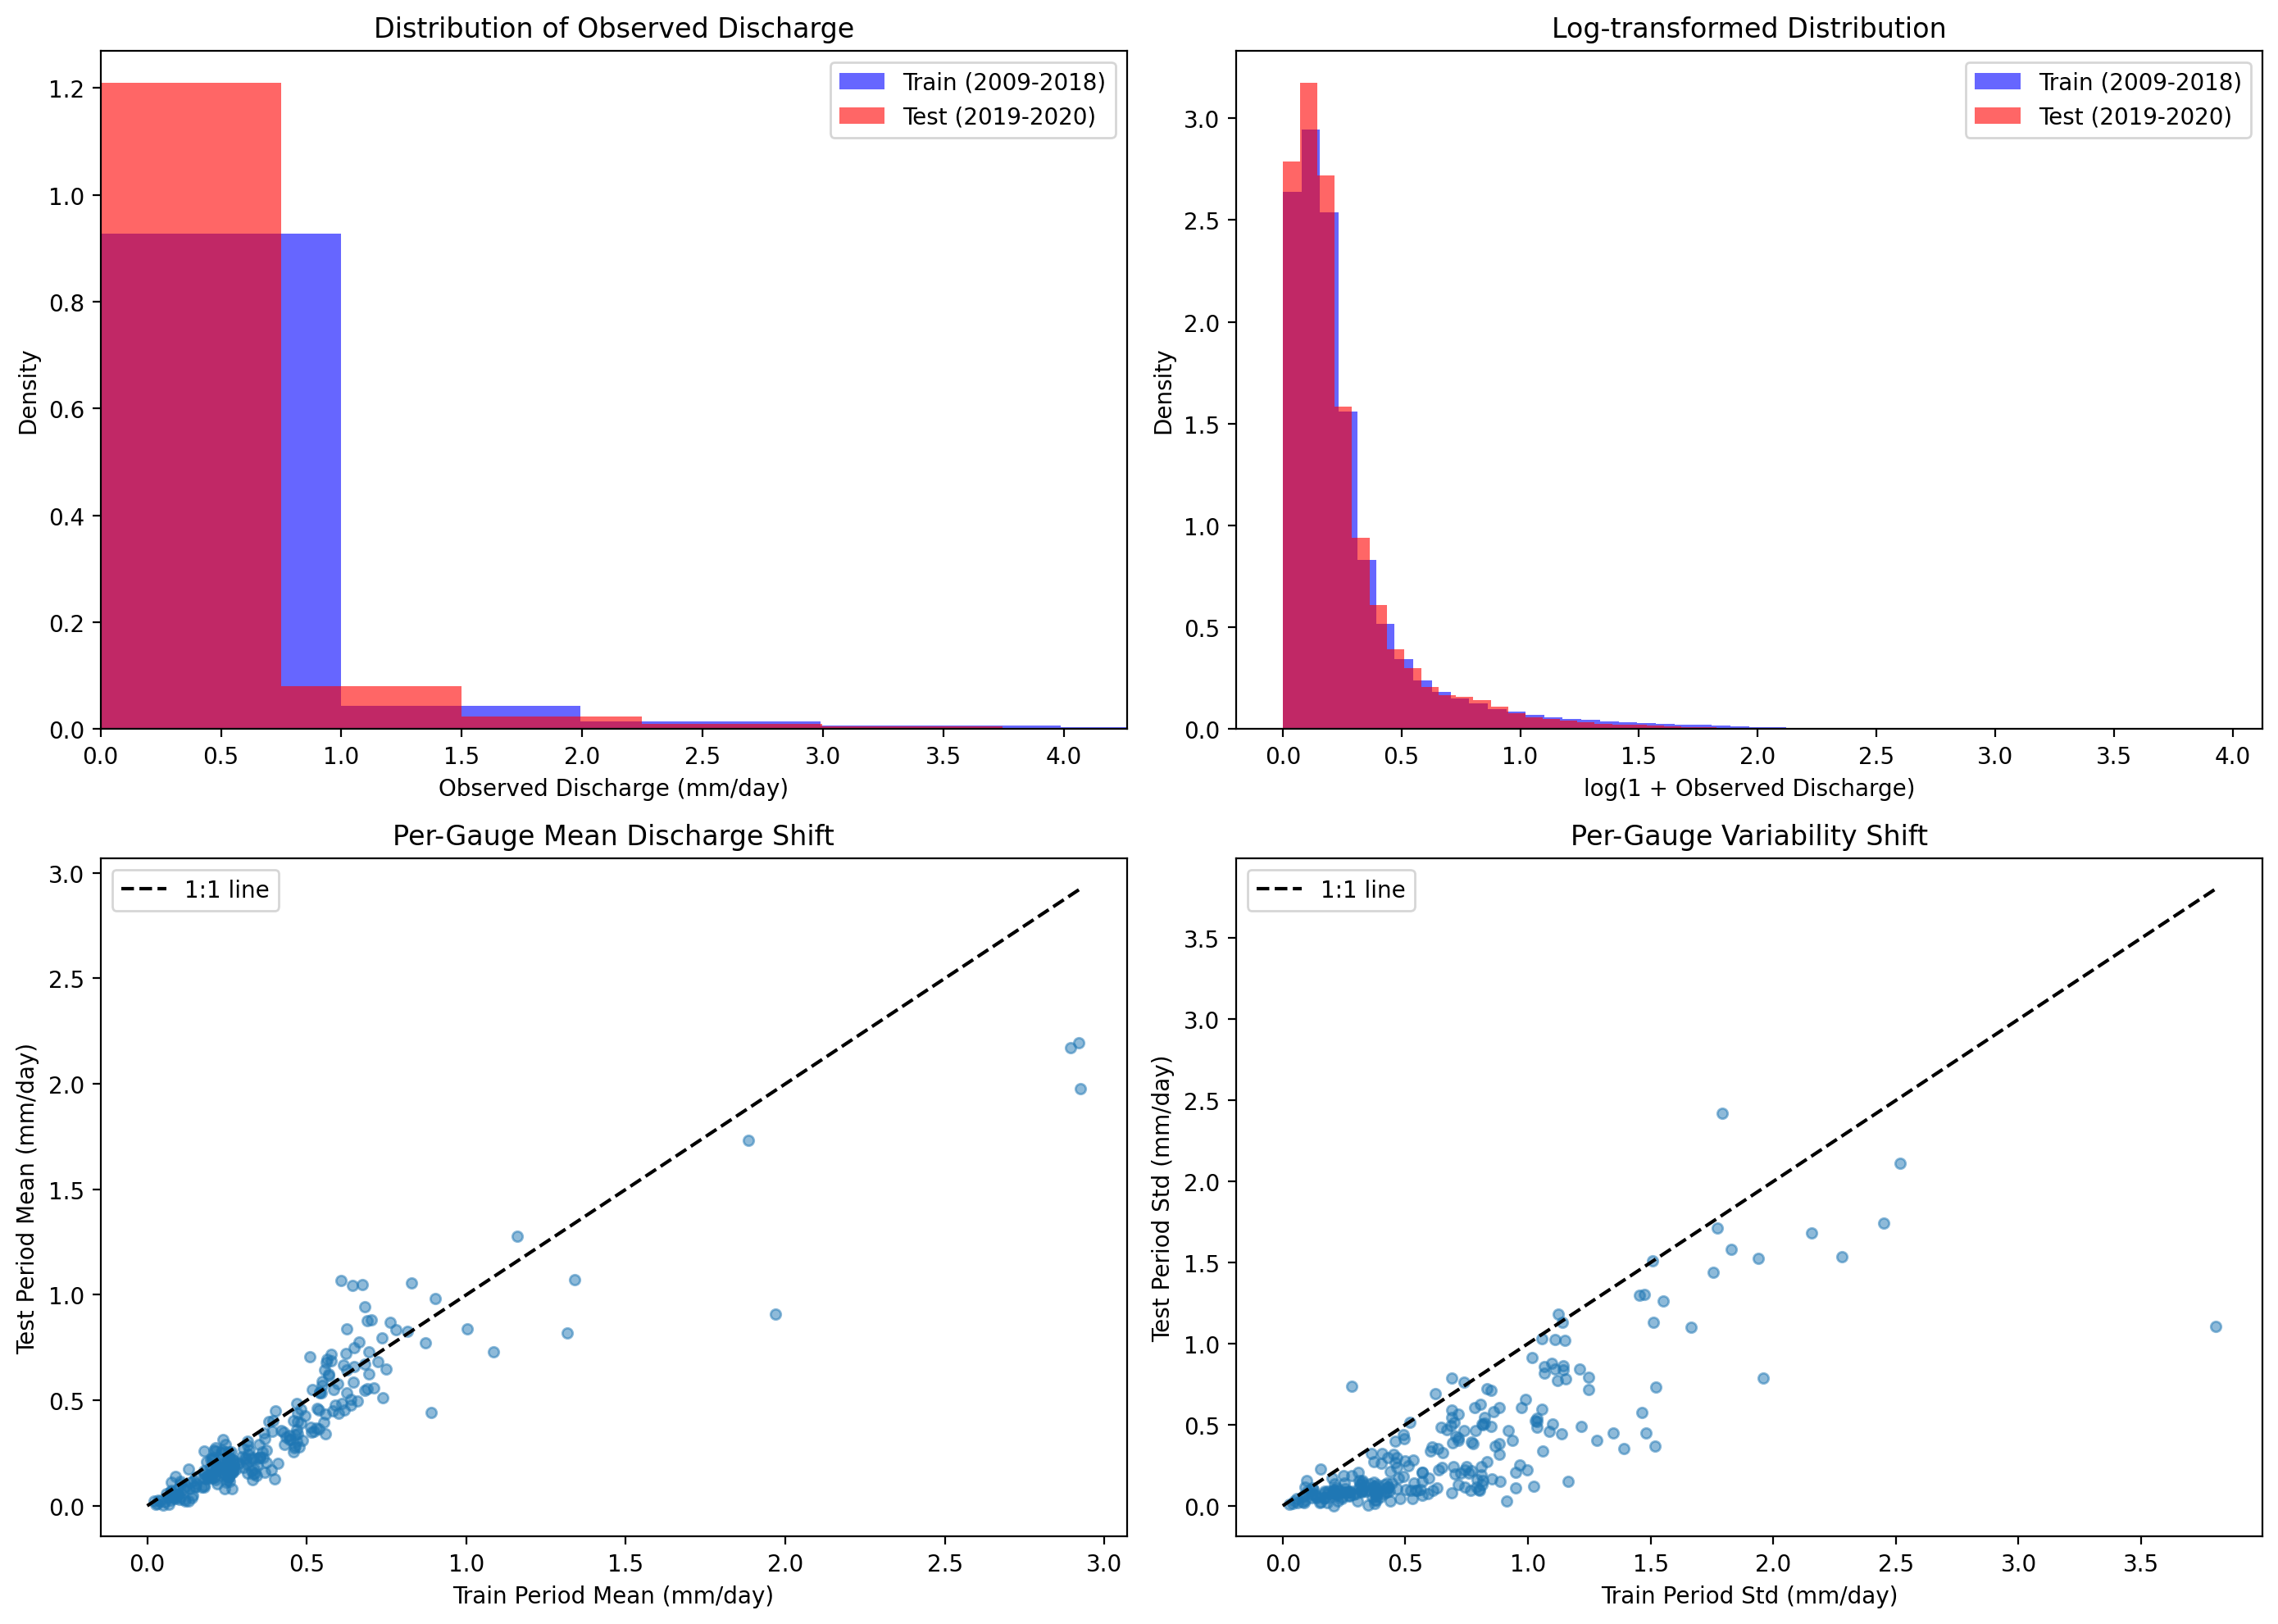

In [44]:
# 3. Visual comparison: Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution of observed discharge
ax1 = axes[0, 0]
ax1.hist(
    train_obs_arr,
    bins=50,
    alpha=0.6,
    label="Train (2009-2018)",
    density=True,
    color="blue",
)
ax1.hist(
    test_obs_arr, bins=50, alpha=0.6, label="Test (2019-2020)", density=True, color="red"
)
ax1.set_xlabel("Observed Discharge (mm/day)")
ax1.set_ylabel("Density")
ax1.set_title("Distribution of Observed Discharge")
ax1.legend()
ax1.set_xlim(0, np.percentile(train_obs_arr, 99))

# Log-scale distribution
ax2 = axes[0, 1]
train_log = np.log1p(train_obs_arr)
test_log = np.log1p(test_obs_arr)
ax2.hist(
    train_log, bins=50, alpha=0.6, label="Train (2009-2018)", density=True, color="blue"
)
ax2.hist(
    test_log, bins=50, alpha=0.6, label="Test (2019-2020)", density=True, color="red"
)
ax2.set_xlabel("log(1 + Observed Discharge)")
ax2.set_ylabel("Density")
ax2.set_title("Log-transformed Distribution")
ax2.legend()

# Per-gauge mean shift
ax3 = axes[1, 0]
ax3.scatter(missing_df["train_mean"], missing_df["test_mean"], alpha=0.5, s=20)
max_val = max(missing_df["train_mean"].max(), missing_df["test_mean"].max())
ax3.plot([0, max_val], [0, max_val], "k--", label="1:1 line")
ax3.set_xlabel("Train Period Mean (mm/day)")
ax3.set_ylabel("Test Period Mean (mm/day)")
ax3.set_title("Per-Gauge Mean Discharge Shift")
ax3.legend()

# Per-gauge std shift
ax4 = axes[1, 1]
ax4.scatter(missing_df["train_std"], missing_df["test_std"], alpha=0.5, s=20)
max_val = max(missing_df["train_std"].max(), missing_df["test_std"].max())
ax4.plot([0, max_val], [0, max_val], "k--", label="1:1 line")
ax4.set_xlabel("Train Period Std (mm/day)")
ax4.set_ylabel("Test Period Std (mm/day)")
ax4.set_title("Per-Gauge Variability Shift")
ax4.legend()

plt.tight_layout()
plt.show()


In [45]:
# 4. Model Bias Analysis: How does the model prediction differ between periods?
print("\n3. MODEL PREDICTION BIAS ANALYSIS")
print("-" * 40)

train_sim_arr = np.array(train_period_sim)
test_sim_arr = np.array(test_period_sim)

# Bias = mean(sim) - mean(obs)
train_bias = np.mean(train_sim_arr) - np.mean(train_obs_arr)
test_bias = np.mean(test_sim_arr) - np.mean(test_obs_arr)

print(
    f"Train period bias: {train_bias:.4f} mm/day ({train_bias / np.mean(train_obs_arr) * 100:.1f}%)"
)
print(
    f"Test period bias:  {test_bias:.4f} mm/day ({test_bias / np.mean(test_obs_arr) * 100:.1f}%)"
)

# Check if model is systematically over/under-predicting
print(
    f"\nTrain: mean(obs)={np.mean(train_obs_arr):.4f}, mean(sim)={np.mean(train_sim_arr):.4f}"
)
print(
    f"Test:  mean(obs)={np.mean(test_obs_arr):.4f}, mean(sim)={np.mean(test_sim_arr):.4f}"
)

# 5. Yearly trend analysis
print("\n4. YEARLY PERFORMANCE TREND")
print("-" * 40)
if "mswep" in nse_pivot_tables:
    yearly_medians = nse_pivot_tables["mswep"].median()
    for col in yearly_medians.index:
        if isinstance(col, int):
            print(f"  {col}: median NSE = {yearly_medians[col]:.3f}")
    print(
        f"\n  2009-2018 period: median NSE = {yearly_medians.get('2009-2018', np.nan):.3f}"
    )
    print(
        f"  2019-2020 period: median NSE = {yearly_medians.get('2019-2020', np.nan):.3f}"
    )



3. MODEL PREDICTION BIAS ANALYSIS
----------------------------------------
Train period bias: -0.0244 mm/day (-6.0%)
Test period bias:  -0.0036 mm/day (-1.0%)

Train: mean(obs)=0.4071, mean(sim)=0.3827
Test:  mean(obs)=0.3407, mean(sim)=0.3371

4. YEARLY PERFORMANCE TREND
----------------------------------------
  2009: median NSE = 0.642
  2010: median NSE = 0.751
  2011: median NSE = 0.672
  2012: median NSE = 0.820
  2013: median NSE = 0.763
  2014: median NSE = 0.484
  2015: median NSE = 0.437
  2016: median NSE = 0.594
  2017: median NSE = 0.500
  2018: median NSE = 0.613
  2019: median NSE = 0.081
  2020: median NSE = 0.174

  2009-2018 period: median NSE = 0.725
  2019-2020 period: median NSE = 0.252


In [46]:
# 5. Extreme Events Analysis: Are there more extremes in 2019-2020?
print("\n5. EXTREME EVENTS ANALYSIS")
print("-" * 40)

# Define extreme as values above 95th percentile of training data
train_q95 = np.percentile(train_obs_arr, 95)
train_q99 = np.percentile(train_obs_arr, 99)

train_extreme_95 = (train_obs_arr > train_q95).sum() / len(train_obs_arr) * 100
test_extreme_95 = (test_obs_arr > train_q95).sum() / len(test_obs_arr) * 100

train_extreme_99 = (train_obs_arr > train_q99).sum() / len(train_obs_arr) * 100
test_extreme_99 = (test_obs_arr > train_q99).sum() / len(test_obs_arr) * 100

print(f"Using train period thresholds: Q95={train_q95:.4f}, Q99={train_q99:.4f}")
print("\nDays exceeding Q95 threshold:")
print(f"  Train: {train_extreme_95:.2f}% (by definition ~5%)")
print(f"  Test:  {test_extreme_95:.2f}%")
print("\nDays exceeding Q99 threshold:")
print(f"  Train: {train_extreme_99:.2f}% (by definition ~1%)")
print(f"  Test:  {test_extreme_99:.2f}%")

# 6. Summary and potential causes
print("\n" + "=" * 60)
print("SUMMARY OF POTENTIAL CAUSES FOR POOR 2019-2020 PERFORMANCE")
print("=" * 60)
print("""
1. DISTRIBUTION SHIFT: Check if test period has systematically different
   discharge patterns (drought/flood years, climate anomalies)
   
2. DATA QUALITY: Higher missing data rates in test period may affect metrics

3. NON-STATIONARITY: The watershed behavior may have changed due to:
   - Land use changes
   - Climate change effects
   - Changes in water management (dams, irrigation)
   
4. EXTREME EVENTS: If 2019-2020 had unusual extreme events not seen
   in training, the model may fail to extrapolate

5. MODEL OVERFITTING: Model may have overfit to training period patterns
   that don't generalize to the test period

RECOMMENDED NEXT STEPS:
- Compare meteorological forcing data between periods
- Check for any data quality issues in 2019-2020
- Analyze individual gauges with largest performance drops
- Consider retraining with a validation split from the full period
""")



5. EXTREME EVENTS ANALYSIS
----------------------------------------
Using train period thresholds: Q95=1.4208, Q99=4.2610

Days exceeding Q95 threshold:
  Train: 5.00% (by definition ~5%)
  Test:  3.72%

Days exceeding Q99 threshold:
  Train: 1.00% (by definition ~1%)
  Test:  0.39%

SUMMARY OF POTENTIAL CAUSES FOR POOR 2019-2020 PERFORMANCE

1. DISTRIBUTION SHIFT: Check if test period has systematically different
   discharge patterns (drought/flood years, climate anomalies)

2. DATA QUALITY: Higher missing data rates in test period may affect metrics

3. NON-STATIONARITY: The watershed behavior may have changed due to:
   - Land use changes
   - Climate change effects
   - Changes in water management (dams, irrigation)

4. EXTREME EVENTS: If 2019-2020 had unusual extreme events not seen
   in training, the model may fail to extrapolate

5. MODEL OVERFITTING: Model may have overfit to training period patterns
   that don't generalize to the test period

RECOMMENDED NEXT STEPS:
- Comp

In [48]:
# 6. Identify gauges with largest performance drops
print("\n6. GAUGES WITH LARGEST PERFORMANCE DROPS")
print("-" * 40)

if "mswep" in nse_pivot_tables:
    pivot = nse_pivot_tables["mswep"]
    if "2009-2018" in pivot.columns and "2019-2020" in pivot.columns:
        pivot["nse_drop"] = pivot["2009-2018"] - pivot["2019-2020"]

        # Sort by largest drop
        worst_drops = pivot.sort_values("nse_drop", ascending=False).head(20)

        print("\nTop 20 gauges with largest NSE drop from train to test period:")
        print(worst_drops[["2009-2018", "2019-2020", "nse_drop"]].to_string())

        # Statistics on drops
        print("\nDrop statistics across all gauges:")
        print(f"  Mean drop: {pivot['nse_drop'].mean():.3f}")
        print(f"  Median drop: {pivot['nse_drop'].median():.3f}")
        print(f"  Gauges with >0.3 drop: {(pivot['nse_drop'] > 0.3).sum()}")
        print(f"  Gauges that improved: {(pivot['nse_drop'] < 0).sum()}")



6. GAUGES WITH LARGEST PERFORMANCE DROPS
----------------------------------------

Top 20 gauges with largest NSE drop from train to test period:
period    2009-2018    2019-2020     nse_drop
gauge_id                                     
19135      0.756127 -2753.675995  2754.432122
19128      0.712875  -110.371963   111.084839
78261      0.317211  -108.144331   108.461542
19127      0.754203  -106.830551   107.584754
77270      0.785830   -61.484347    62.270177
77336      0.555541   -34.226516    34.782057
78231      0.687924   -15.511569    16.199493
78225      0.571990   -15.537688    16.109678
76500      0.764900    -8.234038     8.998939
77288      0.794139    -6.880640     7.674779
77285      0.820922    -6.288158     7.109080
76518      0.583445    -5.975109     6.558554
77246      0.819857    -5.606697     6.426554
78050      0.329203    -5.789584     6.118787
77362      0.369703    -5.507356     5.877059
84295      0.295052    -5.262544     5.557596
77245      0.796366    -4

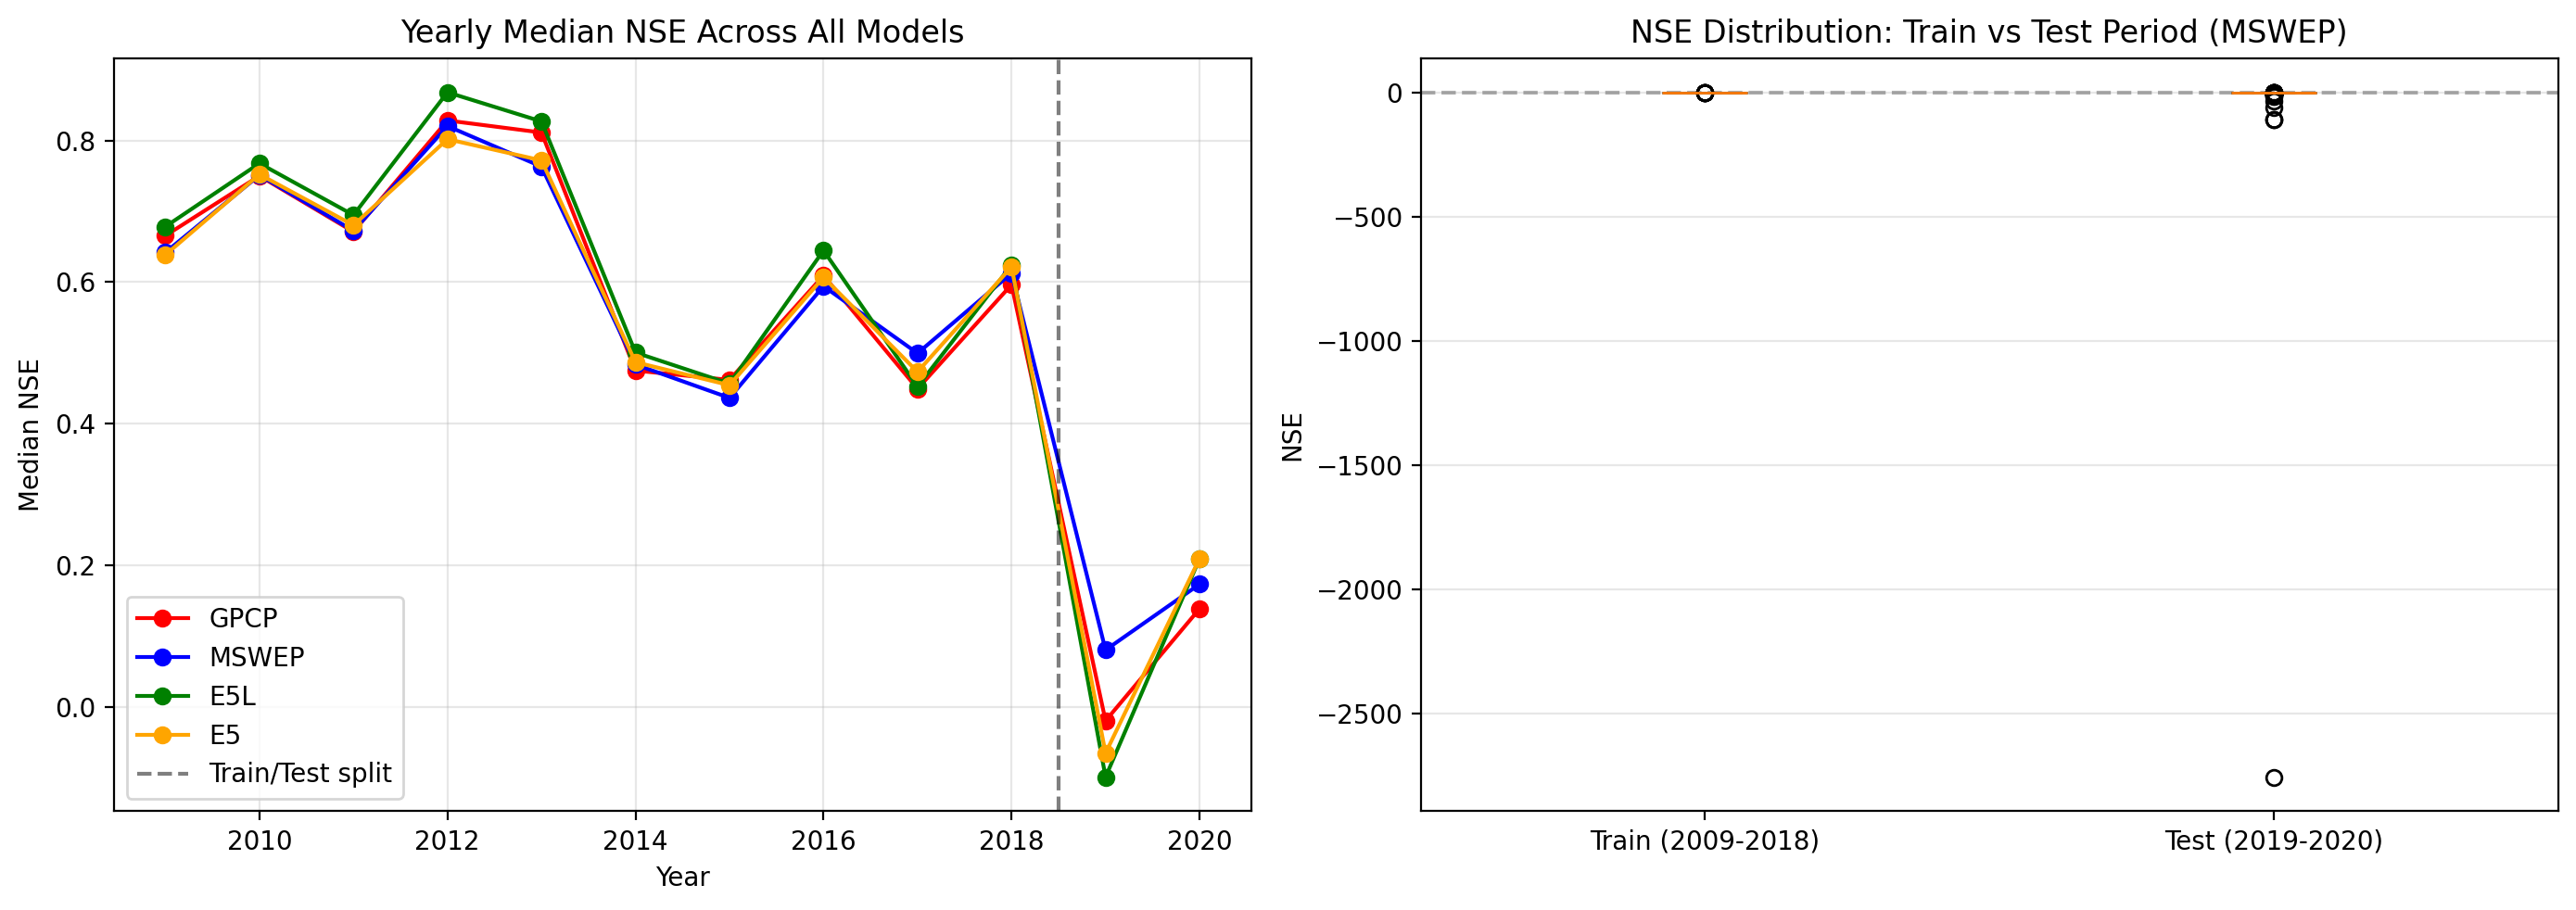

In [50]:
# 7. Yearly performance trend visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot yearly median NSE for all models
ax1 = axes[0]
colors = {"gpcp": "red", "mswep": "blue", "e5l": "green", "e5": "orange"}

for model in ["gpcp", "mswep", "e5l", "e5"]:
    if model in nse_pivot_tables:
        pivot = nse_pivot_tables[model]
        years = [c for c in pivot.columns if isinstance(c, int)]
        yearly_medians = [pivot[y].median() for y in years]
        ax1.plot(
            years, yearly_medians, marker="o", label=model.upper(), color=colors[model]
        )

ax1.axvline(x=2018.5, color="black", linestyle="--", alpha=0.5, label="Train/Test split")
ax1.set_xlabel("Year")
ax1.set_ylabel("Median NSE")
ax1.set_title("Yearly Median NSE Across All Models")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot distribution of NSE by period
ax2 = axes[1]
if "mswep" in nse_pivot_tables:
    pivot = nse_pivot_tables["mswep"]
    if "2009-2018" in pivot.columns and "2019-2020" in pivot.columns:
        data_to_plot = [pivot["2009-2018"].dropna(), pivot["2019-2020"].dropna()]
        bp = ax2.boxplot(
            data_to_plot,
            tick_labels=["Train (2009-2018)", "Test (2019-2020)"],
            patch_artist=True,
        )
        bp["boxes"][0].set_facecolor("lightblue")
        bp["boxes"][1].set_facecolor("lightcoral")
        ax2.set_ylabel("NSE")
        ax2.set_title("NSE Distribution: Train vs Test Period (MSWEP)")
        ax2.axhline(y=0, color="black", linestyle="--", alpha=0.3)
        ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()


<Axes: xlabel='date'>

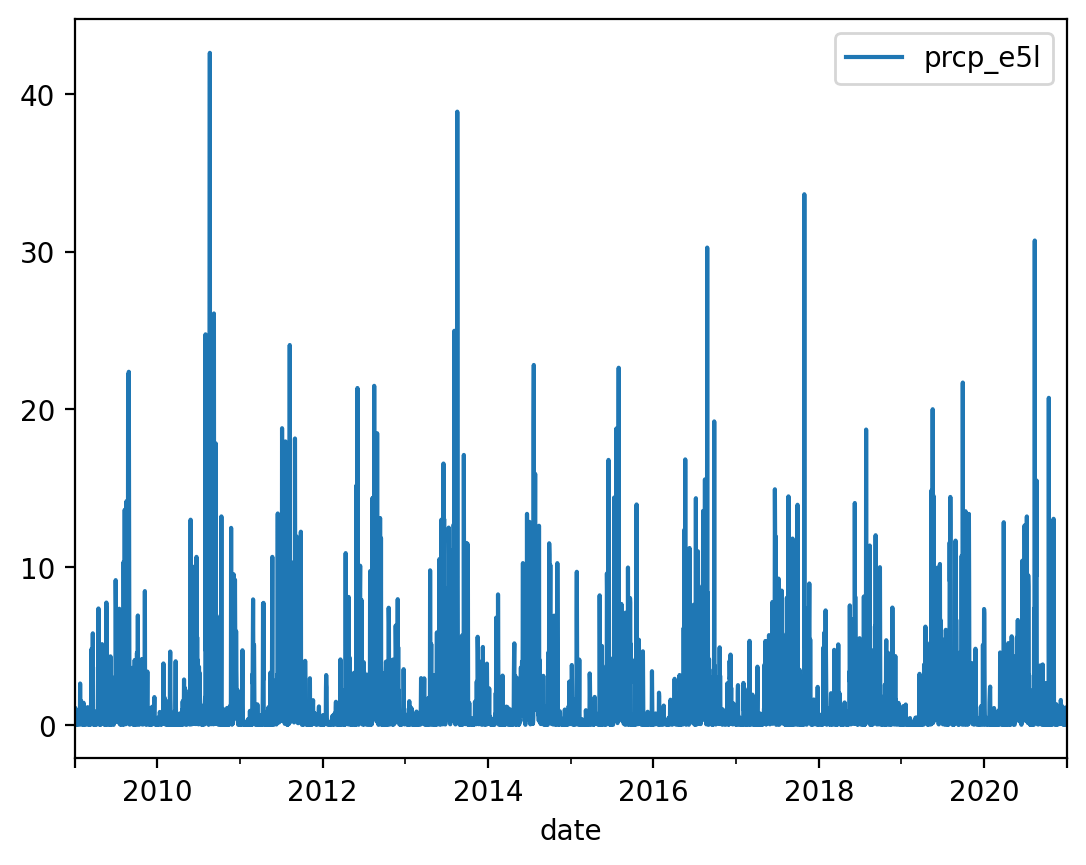

In [64]:
import xarray as xr

with xr.open_dataset(
    "/home/dmbrmv/Development/Dissertation/data/time_series/1151.nc"
) as f:
    df = f.to_dataframe()


df.loc["2009":, ["prcp_e5l"]].plot()


### Rest gauges

In [ ]:
lstm_pathes = {
    "gpcp": "../data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/test/model_epoch024/test_results.p",
    "e5": "../data/lstm_configs/model_runs/cudalstm_q_mm_day_era5_no_autocorr_static_1203_220232/test/model_epoch020/test_results.p",
    "e5l": "../data/lstm_configs/model_runs/cudalstm_q_mm_day_era5l_no_autocorr_static_1003_133332/test/model_epoch026/test_results.p",
    "mswep": "../data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/test/model_epoch024/test_results.p",
}

cfg_pathes = {
    "gpcp": {
        "path": Path(
            "../data/lstm_configs/model_runs/cudalstm_q_mm_day_gpcp_no_autocorr_static_1203_080402/config.yml"
        ),
        "epoch": 24,
    },
    "mswep": {
        "path": Path(
            "../data/lstm_configs/model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/config.yml"
        ),
        "epoch": 24,
    },
}

with open("../data/models/fine_tune/rest_gauges.txt", "w") as the_file:
    for gauge_name in rest_index:
        the_file.write(f"{int(gauge_name)}\n")
lstm_cfg = cfg_pathes["mswep"]["path"]
epoch = cfg_pathes["mswep"]["epoch"]

cfg_run = Config(lstm_cfg)

cfg_run.update_config(
    {
        "train_basin_file": "../data/models/fine_tune/rest_gauges.txt",
        "validate_n_random_basins": len(ft_index),
        "validation_basin_file": "../data/models/fine_tune/rest_gauges.txt",
        "test_basin_file": "../data/models/fine_tune/rest_gauges.txt",
        "test_start_date": "01/01/2009",
        "test_end_date": "31/12/2020",
    }
)
tester = get_tester(cfg=cfg_run, run_dir=cfg_run.run_dir, period="test", init_model=True)
pred_results = tester.evaluate(epoch=epoch, save_results=True)

# Evaluation: 100%|██████████| 731/731 [02:43<00:00,  4.46it/s]


In [10]:
yearly_nse_data = []

print("Calculating yearly and period NSE for GPCP simulation results...")

if not pred_results:
    print(
        "No prediction results found. Please ensure the evaluation cell above ran successfully."
    )
else:
    for gauge_id, result in pred_results.items():
        # Extract data from NeuralHydrology result
        # Assuming structure matches previous cells: result["1D"]["xr"] is an xarray Dataset
        try:
            df = result["1D"]["xr"].to_dataframe().loc["2009":,]
        except KeyError:
            print(f"No data found for gauge {gauge_id} in the specified period.")
            continue

        # Handle multi-index if present (usually it's date/basin)
        if isinstance(df.index, pd.MultiIndex):
            df = df.droplevel(1)

        # Group by year
        for year, group in df.groupby(df.index.year):
            obs = group["q_mm_day_obs"]
            sim = group["q_mm_day_sim"]

            # Calculate NSE if we have enough data
            if len(obs.dropna()) > 10:
                try:
                    metrics = evaluate_model(observed=obs, simulated=sim)
                    nse = metrics["NSE"]
                except Exception:
                    nse = np.nan
            else:
                nse = np.nan

            yearly_nse_data.append({"gauge_id": gauge_id, "period": year, "nse": nse})

        # Calculate specific periods
        periods = {"2009-2018": df.loc["2009":"2018"], "2019-2020": df.loc["2019":"2020"]}

        for p_name, p_df in periods.items():
            nse = np.nan
            if len(p_df) > 0:
                obs = p_df["q_mm_day_obs"]
                sim = p_df["q_mm_day_sim"]
                if len(obs.dropna()) > 10:
                    try:
                        metrics = evaluate_model(observed=obs, simulated=sim)
                        nse = metrics["NSE"]
                    except Exception:
                        pass
            yearly_nse_data.append({"gauge_id": gauge_id, "period": p_name, "nse": nse})

    if not yearly_nse_data:
        print("No NSE data calculated.")
    else:
        # Create pivot table: Rows=Gauge, Cols=Period
        nse_df = pd.DataFrame(yearly_nse_data)

        # Ensure 'period' column exists even if empty (though yearly_nse_data check handles empty list)
        if "period" not in nse_df.columns:
            print("Error: 'period' column missing from data.")
        else:
            nse_pivot = nse_df.pivot(index="gauge_id", columns="period", values="nse")

            # Reorder columns: Years first, then periods
            year_cols = sorted([c for c in nse_pivot.columns if isinstance(c, int)])
            period_cols = ["2009-2018", "2019-2020"]
            # Ensure period columns exist (in case of missing data)
            period_cols = [c for c in period_cols if c in nse_pivot.columns]
            nse_pivot = nse_pivot[year_cols + period_cols]

            # Display with heatmap styling
            # vmin=-1 to handle poor performance without skewing the color scale too much for "okay" values
            styled_df = nse_pivot.style.background_gradient(
                cmap="RdYlGn", vmin=0, vmax=1
            ).format("{:.2f}")
            # display(styled_df)


Calculating yearly and period NSE for GPCP simulation results...


### Plots

In [65]:
# Process LSTM pickle files and create dataframes with comprehensive metrics
lstm_dataset_dfs = {}

for _dataset_name, _pickle_path in lstm_pathes.items():
    print(f"Processing LSTM {_dataset_name}...")

    with open(_pickle_path, "rb") as _f:
        _lstm_data = pickle.load(_f)

    lstm_dataset_dfs[_dataset_name] = {}

    for _gauge_id, _gauge_results in _lstm_data.items():
        if _gauge_id in ft_index:
            # Extract observed and simulated data
            _df_data = (
                _gauge_results["1D"]["xr"]
                .to_dataframe()
                .droplevel(1)
                .rename(columns={"q_mm_day_obs": "obs", "q_mm_day_sim": "sim"})
            )
            lstm_dataset_dfs[_dataset_name][_gauge_id] = _df_data
        else:
            continue

Processing LSTM gpcp...
Processing LSTM e5...
Processing LSTM e5l...
Processing LSTM mswep...


In [38]:
img_dir = Path("../data/images/series_before_finetuning")
img_dir.mkdir(parents=True, exist_ok=True)

In [56]:
import matplotlib.pyplot as plt

# Create output directory
img_dir = Path("../data/images/series_before_finetuning")
img_dir.mkdir(parents=True, exist_ok=True)

# Get list of gauges from the first dataset (assuming all have same gauges)
first_dataset = next(iter(lstm_dataset_dfs.values()))
gauge_ids = first_dataset.keys()

for gauge_id in gauge_ids:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot observed data (only once)
    # We can take observed from any dataset as it should be the same
    obs_data = lstm_dataset_dfs["mswep"][gauge_id]["obs"]
    ax.plot(
        obs_data.index,
        obs_data,
        label="Observed",
        color="black",
        linewidth=1.5,
        alpha=0.7,
    )

    title_parts = [f"Gauge {gauge_id}"]

    # Plot simulations for each dataset
    colors = {
        "gpcp": "red",
        "mswep": "blue",
        "e5l": "green",
        "e5": "orange",
        "ealstm": "purple",
    }

    for dataset_name, dataset_dfs in lstm_dataset_dfs.items():
        if gauge_id in dataset_dfs:
            sim_data = dataset_dfs[gauge_id]["sim"]

            # Calculate metrics
            metrics = evaluate_model(observed=obs_data, simulated=sim_data)

            # Add to plot
            ax.plot(
                sim_data.index,
                sim_data,
                label=f"{dataset_name} (NSE: {metrics['NSE']:.2f})",
                color=colors.get(dataset_name, "gray"),
                linewidth=1,
                alpha=0.6,
            )

            # Add metrics to title (simplified)
            title_parts.append(
                f"{dataset_name}: NSE={metrics['NSE']:.2f}, KGE={metrics['KGE']:.2f}"
            )

    ax.set_xlabel("Date")
    ax.set_ylabel("Discharge (mm/day)")
    ax.set_title("\n".join([title_parts[0], " | ".join(title_parts[1:])]), fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Save figure
    fig.tight_layout()
    fig.savefig(img_dir / f"gauge_{gauge_id}_comparison.png", dpi=150)
    plt.close(fig)

### Fine-tune for poor-performing gauges